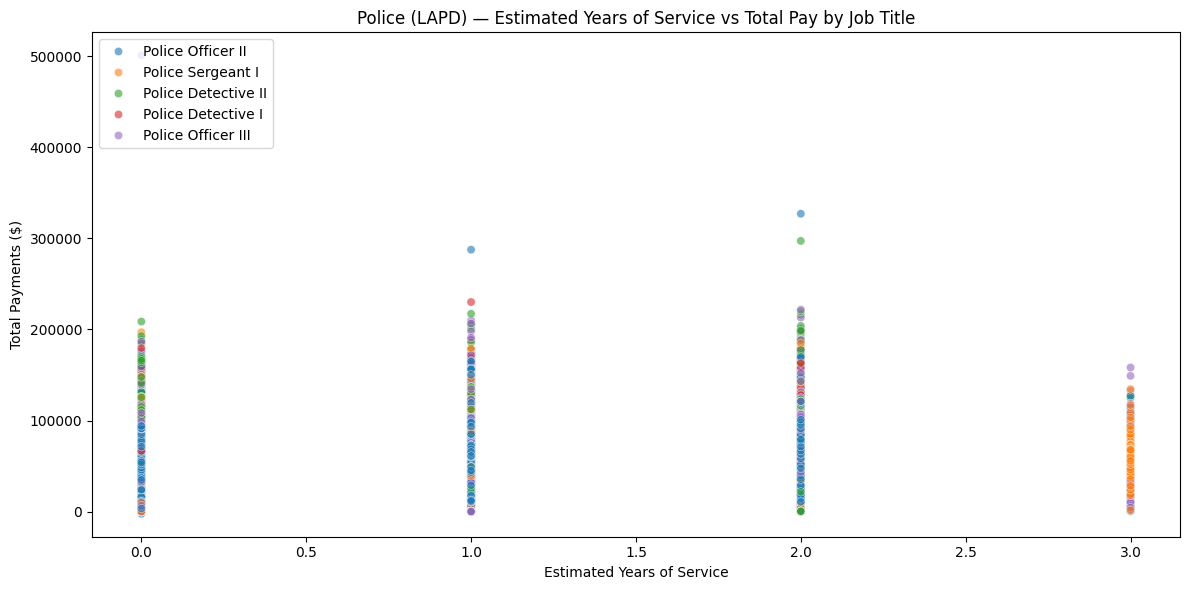

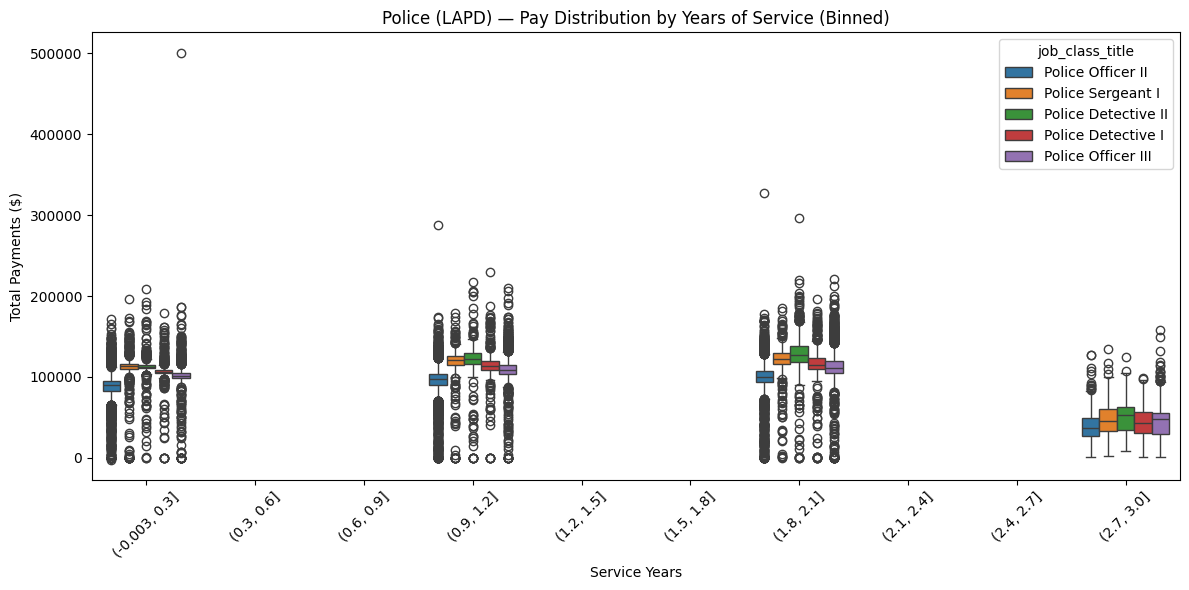

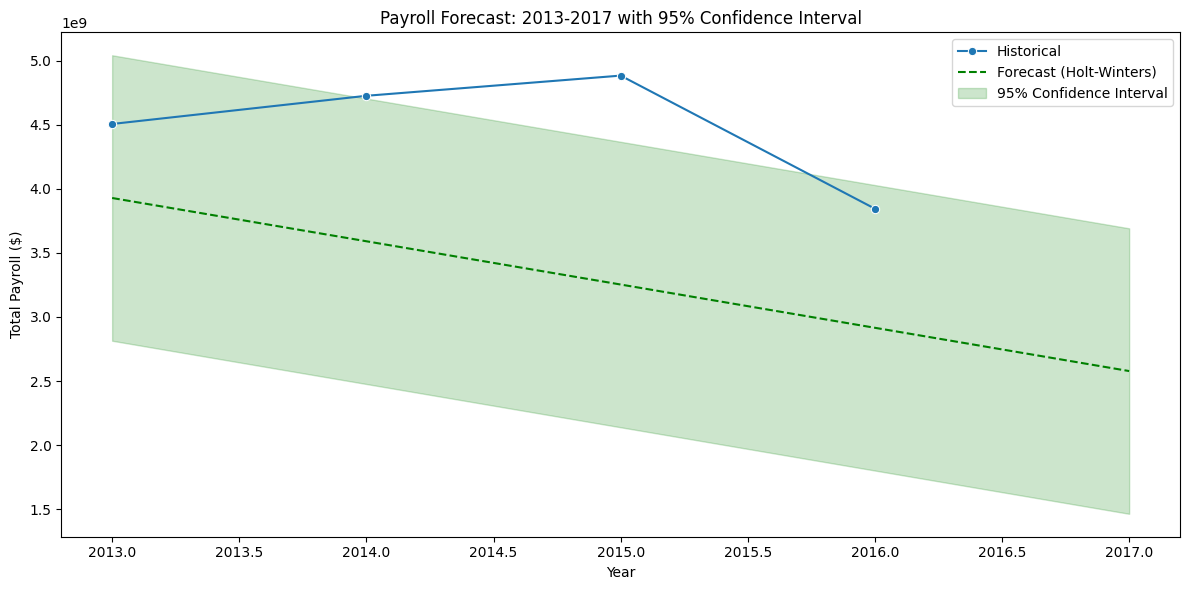

Expected total payroll cost in 2017: $2,577,816,663.00
95% CI: $1,463,971,209.22 - $3,691,662,116.78


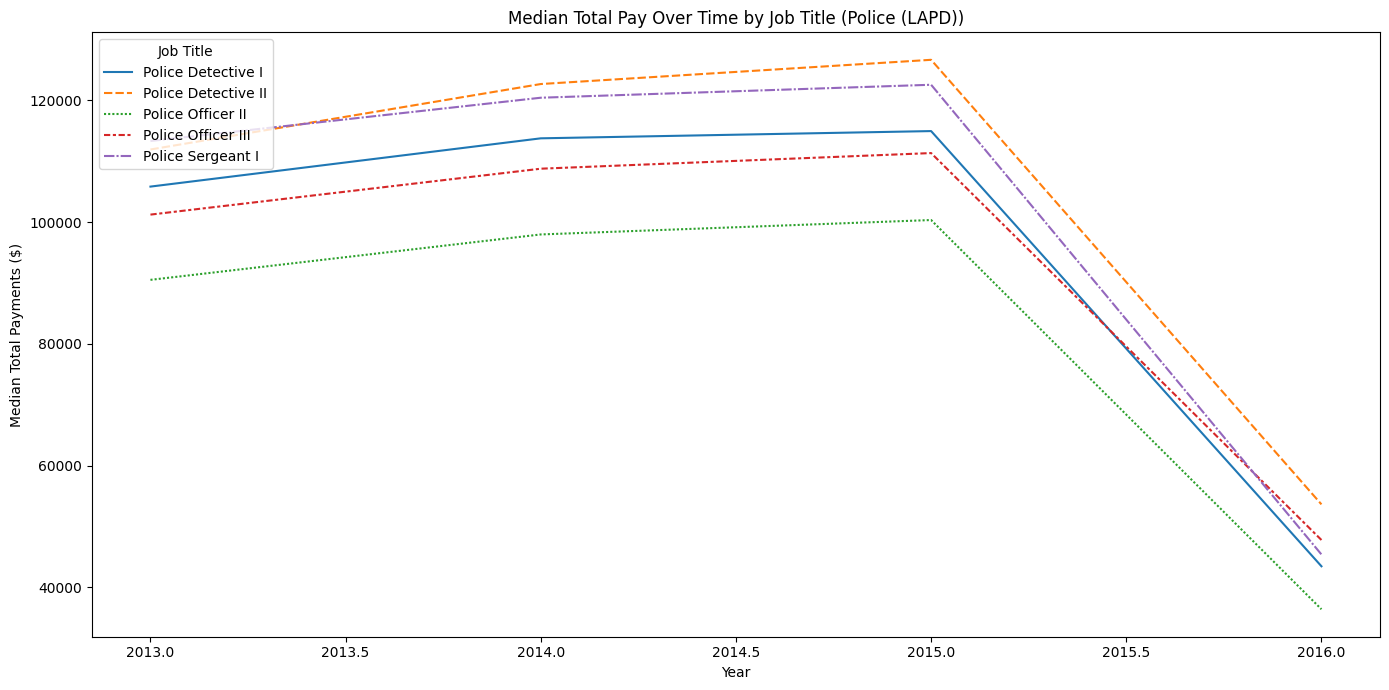

In [19]:
# ========================
# Libraries
# ========================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

warnings.filterwarnings("ignore")

# ========================
# Load + Clean Data
# ========================
df = pd.read_csv(r"C:\Users\jason\OneDrive\Desktop\la-city-payroll-analysis\data\data.csv")

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Drop missing or malformed rows
df = df[df['total_payments'].notnull()]
df = df[df['year'].notnull()]
df = df[df['year'] > 2005]

# Convert total_payments to numeric (fixes string with $)
df['total_payments'] = df['total_payments'].replace('[\$,]', '', regex=True).astype(float)

# ========================
# Estimate "Years of Service"
# ========================
df['estimated_start_year'] = df.groupby('job_class_title')['year'].transform('min')
df['estimated_years_of_service'] = df['year'] - df['estimated_start_year']
df = df[df['estimated_years_of_service'] >= 0]

# ========================
# PART 1 — Pay vs Service (Department Focus)
# ========================
selected_dept = 'Police (LAPD)'  # 👈 Change to target another department
dept_df = df[df['department_title'].str.lower() == selected_dept.lower()]

# Top 5 job titles in this department
top_jobs = dept_df['job_class_title'].value_counts().head(5).index
dept_subset = dept_df[dept_df['job_class_title'].isin(top_jobs)]

# Scatterplot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=dept_subset,
                x='estimated_years_of_service',
                y='total_payments',
                hue='job_class_title',
                alpha=0.6)
plt.title(f"{selected_dept} — Estimated Years of Service vs Total Pay by Job Title")
plt.xlabel("Estimated Years of Service")
plt.ylabel("Total Payments ($)")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Optional: Add boxplot with binned service years
if not dept_subset.empty:
    dept_subset['service_bins'] = pd.cut(dept_subset['estimated_years_of_service'], bins=10)

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=dept_subset, x='service_bins', y='total_payments', hue='job_class_title')
    plt.title(f"{selected_dept} — Pay Distribution by Years of Service (Binned)")
    plt.xlabel("Service Years")
    plt.ylabel("Total Payments ($)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ No records found for selected department '{selected_dept}' with top job titles.")

# ========================
# PART 2 — Payroll Forecast (Holt-Winters)
# ========================

# Forecast Config

# Forecast Config
forecast_start = 2013
forecast_end = 2017
forecast_years = forecast_end - forecast_start + 1

# Prepare payroll trend data (yearly sum)
payroll_trend = df.groupby('year')['total_payments'].sum().sort_index()

# Fit Holt-Winters model (additive trend, no seasonality)
hw_model = ExponentialSmoothing(payroll_trend, trend='add', seasonal=None)
hw_fit = hw_model.fit()

# Forecast
forecast_hw = hw_fit.forecast(forecast_years)

# Calculate residuals and standard deviation for confidence intervals
residuals = hw_fit.fittedvalues - payroll_trend
residual_std = residuals.std()

# Confidence interval multiplier for ~95% CI (normal dist)
z = 1.96

# Create DataFrame for forecast + intervals
forecast_years_range = np.arange(forecast_start, forecast_end + 1)
forecast_df = pd.DataFrame({
    'year': forecast_years_range,
    'forecast': forecast_hw,
    'lower_ci': forecast_hw - z * residual_std,
    'upper_ci': forecast_hw + z * residual_std
})

# Plot historical + forecast with confidence intervals
plt.figure(figsize=(12, 6))
sns.lineplot(x=payroll_trend.index, y=payroll_trend.values, label='Historical', marker='o')
plt.plot(forecast_df['year'], forecast_df['forecast'], linestyle='--', color='green', label='Forecast (Holt-Winters)')
plt.fill_between(forecast_df['year'], forecast_df['lower_ci'], forecast_df['upper_ci'], color='green', alpha=0.2, label='95% Confidence Interval')
plt.title(f"Payroll Forecast: {forecast_start}-{forecast_end} with 95% Confidence Interval")
plt.xlabel("Year")
plt.ylabel("Total Payroll ($)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Expected total payroll cost in {forecast_end}: ${forecast_df['forecast'].iloc[-1]:,.2f}")
print(f"95% CI: ${forecast_df['lower_ci'].iloc[-1]:,.2f} - ${forecast_df['upper_ci'].iloc[-1]:,.2f}")

# ========================
# PART 3 — Per Job Title Median Pay per Year
# ========================

# Calculate median pay per job title per year (for top 5 job titles in the selected department)
selected_dept = 'Police (LAPD)'  # Change as needed
dept_df = df[df['department_title'].str.lower() == selected_dept.lower()]
top_jobs = dept_df['job_class_title'].value_counts().head(5).index

median_pay_by_job_year = dept_df[dept_df['job_class_title'].isin(top_jobs)].groupby(['year', 'job_class_title'])['total_payments'].median().reset_index()

# Pivot for nicer visualization (optional)
median_pay_pivot = median_pay_by_job_year.pivot(index='year', columns='job_class_title', values='total_payments')

# Plot median pay over time per job title
plt.figure(figsize=(14, 7))
sns.lineplot(data=median_pay_pivot)
plt.title(f"Median Total Pay Over Time by Job Title ({selected_dept})")
plt.xlabel("Year")
plt.ylabel("Median Total Payments ($)")
plt.legend(title='Job Title', loc='upper left')
plt.tight_layout()
plt.show()

